In [1]:
%matplotlib inline

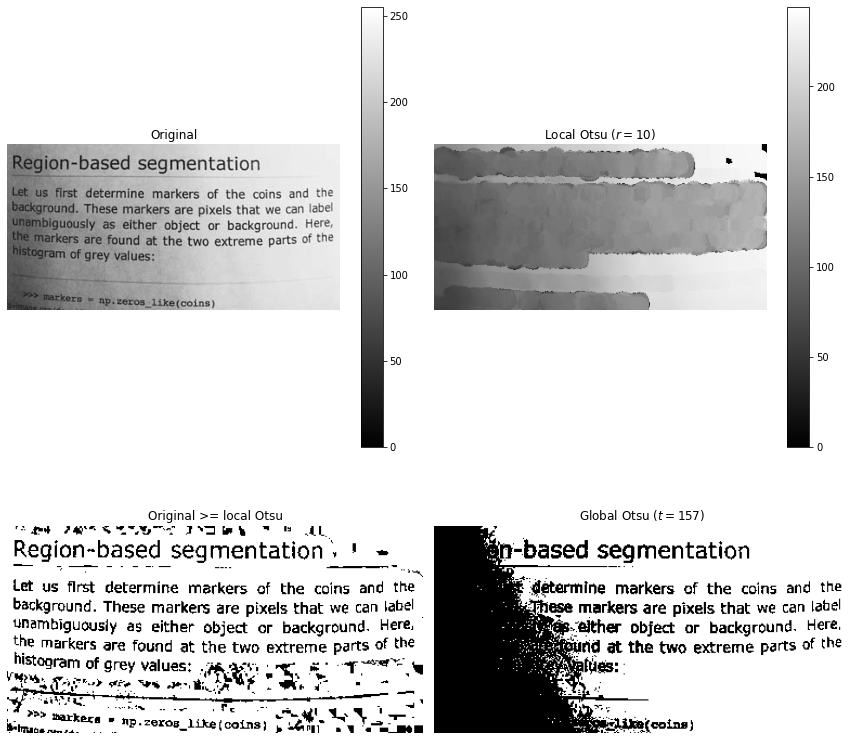

In [8]:
from skimage.filters.rank import otsu
from skimage.filters import threshold_otsu
from skimage import exposure
from skimage import data
from skimage.morphology import disk, ball
import numpy as np
import matplotlib.pyplot as plt

p8 = data.page()

radius = 10
footprint = disk(radius)

# t_loc_otsu is an image
t_loc_otsu = otsu(p8, footprint)
loc_otsu = p8 >= t_loc_otsu

# t_glob_otsu is a scalar
t_glob_otsu = threshold_otsu(p8)
glob_otsu = p8 >= t_glob_otsu

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12),
                         sharex=True, sharey=True)
ax = axes.ravel()

fig.colorbar(ax[0].imshow(p8, cmap=plt.cm.gray), ax=ax[0])
ax[0].set_title('Original')

fig.colorbar(ax[1].imshow(t_loc_otsu, cmap=plt.cm.gray), ax=ax[1])
ax[1].set_title('Local Otsu ($r=%d$)' % radius)

ax[2].imshow(p8 >= t_loc_otsu, cmap=plt.cm.gray)
ax[2].set_title('Original >= local Otsu' % t_glob_otsu)

ax[3].imshow(glob_otsu, cmap=plt.cm.gray)
ax[3].set_title('Global Otsu ($t=%d$)' % t_glob_otsu)

for a in ax:
    a.axis('off')

plt.tight_layout()

The example below performs the same comparison, using a 3D image this time.



In [9]:
brain = exposure.rescale_intensity(data.brain().astype(float))

radius = 5
neighborhood = ball(radius)

# t_loc_otsu is an image
t_loc_otsu = rank.otsu(brain, neighborhood)
loc_otsu = brain >= t_loc_otsu

# t_glob_otsu is a scalar
t_glob_otsu = threshold_otsu(brain)
glob_otsu = brain >= t_glob_otsu

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12),
                         sharex=True, sharey=True)
ax = axes.ravel()

slice_index = 3

fig.colorbar(ax[0].imshow(brain[slice_index], cmap=plt.cm.gray), ax=ax[0])
ax[0].set_title('Original')

fig.colorbar(ax[1].imshow(t_loc_otsu[slice_index], cmap=plt.cm.gray), ax=ax[1])
ax[1].set_title('Local Otsu ($r=%d$)' % radius)

ax[2].imshow(brain[slice_index] >= t_loc_otsu[slice_index], cmap=plt.cm.gray)
ax[2].set_title('Original >= local Otsu' % t_glob_otsu)

ax[3].imshow(glob_otsu[slice_index], cmap=plt.cm.gray)
ax[3].set_title('Global Otsu ($t=%d$)' % t_glob_otsu)

for a in ax:
    a.axis('off')

fig.tight_layout()

AttributeError: module 'skimage.data' has no attribute 'brain'

The following example shows how local Otsu thresholding handles a global
level shift applied to a synthetic image.



In [ ]:
n = 100
theta = np.linspace(0, 10 * np.pi, n)
x = np.sin(theta)
m = (np.tile(x, (n, 1)) * np.linspace(0.1, 1, n) * 128 + 128).astype(np.uint8)

radius = 10
t = rank.otsu(m, disk(radius))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5),
                       sharex=True, sharey=True)

ax[0].imshow(m, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(m >= t, cmap=plt.cm.gray)
ax[1].set_title('Local Otsu ($r=%d$)' % radius)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Image morphology

Local maximum and local minimum are the base operators for gray-level
morphology.

Here is an example of the classical morphological gray-level filters:
opening, closing and morphological gradient.



In [ ]:
from skimage.filters.rank import maximum, minimum, gradient

noisy_image = img_as_ubyte(data.camera())

closing = maximum(minimum(noisy_image, disk(5)), disk(5))
opening = minimum(maximum(noisy_image, disk(5)), disk(5))
grad = gradient(noisy_image, disk(5))

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(noisy_image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(closing, cmap=plt.cm.gray)
ax[1].set_title('Gray-level closing')

ax[2].imshow(opening, cmap=plt.cm.gray)
ax[2].set_title('Gray-level opening')

ax[3].imshow(grad, cmap=plt.cm.gray)
ax[3].set_title('Morphological gradient')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Feature extraction

Local histograms can be exploited to compute local entropy, which is
related to the local image complexity. Entropy is computed using base 2
logarithm, i.e., the filter returns the minimum number of bits needed to
encode local gray-level distribution.

:func:`skimage.filters.rank.entropy` returns the local entropy on a given
structuring element. The following example applies this filter
on 8- and 16-bit images.

<div class="alert alert-info"><h4>Note</h4><p>To better use the available image bit, the function returns 10x entropy
    for 8-bit images and 1000x entropy for 16-bit images.</p></div>



In [ ]:
from skimage import data
from skimage.filters.rank import entropy
from skimage.morphology import disk
import numpy as np
import matplotlib.pyplot as plt

image = data.camera()

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)

fig.colorbar(ax[0].imshow(image, cmap=plt.cm.gray), ax=ax[0])
ax[0].set_title('Image')

fig.colorbar(ax[1].imshow(entropy(image, disk(5)), cmap=plt.cm.gray), ax=ax[1])
ax[1].set_title('Entropy')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Implementation

The central part of the `skimage.filters.rank` filters is built on a sliding
window that updates the local gray-level histogram. This approach limits the
algorithm complexity to O(n) where n is the number of image pixels. The
complexity is also limited with respect to the structuring element size.

In the following, we compare the performance of different implementations
available in `skimage`.



In [ ]:
from time import time

from scipy.ndimage import percentile_filter
from skimage.morphology import dilation
from skimage.filters.rank import median, maximum


def exec_and_timeit(func):
    """Decorator that returns both function results and execution time."""
    def wrapper(*arg):
        t1 = time()
        res = func(*arg)
        t2 = time()
        ms = (t2 - t1) * 1000.0
        return (res, ms)
    return wrapper


@exec_and_timeit
def cr_med(image, footprint):
    return median(image=image, footprint=footprint)


@exec_and_timeit
def cr_max(image, footprint):
    return maximum(image=image, footprint=footprint)


@exec_and_timeit
def cm_dil(image, footprint):
    return dilation(image=image, footprint=footprint)


@exec_and_timeit
def ndi_med(image, n):
    return percentile_filter(image, 50, size=n * 2 - 1)

Comparison between

* `skimage.filters.rank.maximum`
* `skimage.morphology.dilation`

on increasing structuring element size:



In [ ]:
a = data.camera()

rec = []
e_range = range(1, 20, 2)
for r in e_range:
    elem = disk(r + 1)
    rc, ms_rc = cr_max(a, elem)
    rcm, ms_rcm = cm_dil(a, elem)
    rec.append((ms_rc, ms_rcm))

rec = np.asarray(rec)

fig, ax = plt.subplots(figsize=(10, 10), sharey=True)
ax.set_title('Performance with respect to element size')
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Element radius')
ax.plot(e_range, rec)
ax.legend(['filters.rank.maximum', 'morphology.dilate'])

plt.tight_layout()

and increasing image size:



In [ ]:
r = 9
elem = disk(r + 1)

rec = []
s_range = range(100, 1000, 100)
for s in s_range:
    a = (rng.random((s, s)) * 256).astype(np.uint8)
    (rc, ms_rc) = cr_max(a, elem)
    (rcm, ms_rcm) = cm_dil(a, elem)
    rec.append((ms_rc, ms_rcm))

rec = np.asarray(rec)

fig, ax = plt.subplots()
ax.set_title('Performance with respect to image size')
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Image size')
ax.plot(s_range, rec)
ax.legend(['filters.rank.maximum', 'morphology.dilate'])

plt.tight_layout()

Comparison between:

* `skimage.filters.rank.median`
* `scipy.ndimage.percentile_filter`

on increasing structuring element size:



In [ ]:
a = data.camera()

rec = []
e_range = range(2, 30, 4)
for r in e_range:
    elem = disk(r + 1)
    rc, ms_rc = cr_med(a, elem)
    rndi, ms_ndi = ndi_med(a, r)
    rec.append((ms_rc, ms_ndi))

rec = np.asarray(rec)

fig, ax = plt.subplots()
ax.set_title('Performance with respect to element size')
ax.plot(e_range, rec)
ax.legend(['filters.rank.median', 'scipy.ndimage.percentile'])
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Element radius')

Comparison of outcome of the two methods:



In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].set_title('filters.rank.median')
ax[0].imshow(rc, cmap=plt.cm.gray)

ax[1].set_title('scipy.ndimage.percentile')
ax[1].imshow(rndi, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

on increasing image size:



In [ ]:
r = 9
elem = disk(r + 1)

rec = []
s_range = [100, 200, 500, 1000]
for s in s_range:
    a = (rng.random((s, s)) * 256).astype(np.uint8)
    (rc, ms_rc) = cr_med(a, elem)
    rndi, ms_ndi = ndi_med(a, r)
    rec.append((ms_rc, ms_ndi))

rec = np.asarray(rec)

fig, ax = plt.subplots()
ax.set_title('Performance with respect to image size')
ax.plot(s_range, rec)
ax.legend(['filters.rank.median', 'scipy.ndimage.percentile'])
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Image size')

plt.tight_layout()

plt.show()